This project sets up a relatively simple task for a ConvNN. A image contains a circle or random size and position. The goal is to output the position and the size of the circle.
The training and test data was created using the .... script.
This project is aimed at deepening the understanding of the framework and to play more with parameters while keeping the problem set up relatively simple.

A noise filter is added that allows to train on the same data set being able to set a noise level as a transformer. The model is trained for different noise level to see how far it can be pushed.

In [1]:
!git clone https://github.com/SebastianGhafafian/Circle_CNN

Cloning into 'Circle_CNN'...
remote: Enumerating objects: 1069, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 1069 (delta 12), reused 55 (delta 12), pack-reused 1014
Receiving objects: 100% (1069/1069), 42.03 MiB | 23.53 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [4]:
# import libraries
import torch
from torch import nn, save, load
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
import pandas as pd
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import Circle
from Circle_CNN import networks, utils
import zipfile



In [5]:
os.getcwd()

'/content'

In [10]:
path = "./data"
dir_list = os.listdir(path)
len(dir_list)

40002

In [7]:
zip = './Circle_CNN/data/dataset.zip'
zip_training = zipfile.ZipFile(zip, 'r') #Opens the zip file in read mode
zip_training.extractall()

In [9]:
# define the train and val splits
train_split = 0.80
test_split = 1 - train_split
#Hyperparameters
learning_rate = 5e-4
batch_size = 100
epochs = 20
noise_lvl = 0.5

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) # get labels
        self.img_dir = img_dir # store image directory
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        xlabel = self.img_labels.iloc[idx, 1]
        ylabel = self.img_labels.iloc[idx, 2]
        radius = self.img_labels.iloc[idx, 3]
        # apply input transformation
        if self.transform:
            image = self.transform(image)
        # apply target transformation
        if self.target_transform:
            xlabel = self.target_transform(xlabel)
            ylabel = self.target_transform(ylabel)
            radius = self.target_transform(radius)

        return image, np.array([xlabel,ylabel,radius],dtype=np.float32) ####how to I work with



# Data Loader and Data Set

In [12]:
#add gassian noise to training data
data_set = CustomImageDataset(annotations_file="./data/annotations.csv",img_dir="./data",transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    utils.AddGaussianNoise(mean = 0, std = noise_lvl)]))

# set number of training samples
numTrainingSamples = int(len(data_set) * train_split)
# set number of test samples
numTestSamples = int(len(data_set) - numTrainingSamples)
print(numTestSamples, numTrainingSamples)
# draw randomly from data
(trainData, testData) = random_split(data_set,
	[numTrainingSamples, numTestSamples],
	generator=torch.Generator().manual_seed(42))

# define data loader of batch size 50
train_dataloader = DataLoader(trainData, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testData, batch_size=batch_size, shuffle=True)

8000 32000


tensor(2.4535)

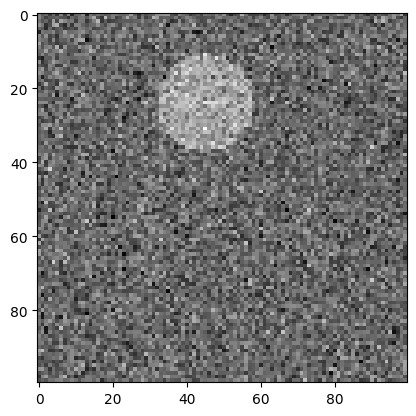

In [13]:
#draw random sample to verify noisy image is created
sample_idx = torch.randint(len(trainData), size=(1,)).item()
img, label = trainData[sample_idx]
plt.imshow(img.squeeze(), cmap = "gray")
label.dtype
torch.max(img)

In [15]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)
model = networks.CustomCNN().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")


cpu
Number of parameters: 270527


In [ ]:
# Initialize the loss function
loss_fn = nn.MSELoss()
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, label) in enumerate(dataloader):
        X = X.to(device)
        label = label.to(device)
        # Compute prediction and loss
        pred = torch.squeeze(model(X))
        loss = loss_fn(pred, label)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, label in dataloader:
            X = X.to(device)
            label = label.to(device)
            pred = torch.squeeze(model(X))
            test_loss += loss_fn(pred, label).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    #correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

#initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
test_loss = []

In [ ]:

# initialize a dictionary to store training history

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    L = test_loop(test_dataloader, model, loss_fn)
    test_loss.append(L)
print("Done!")


Epoch 1
-------------------------------
loss: 2061.169189  [   50/32000]
loss: 304.295380  [ 1050/32000]
loss: 294.180298  [ 2050/32000]
loss: 1664.887939  [ 3050/32000]
loss: 311.804779  [ 4050/32000]
loss: 242.736740  [ 5050/32000]


KeyboardInterrupt: 

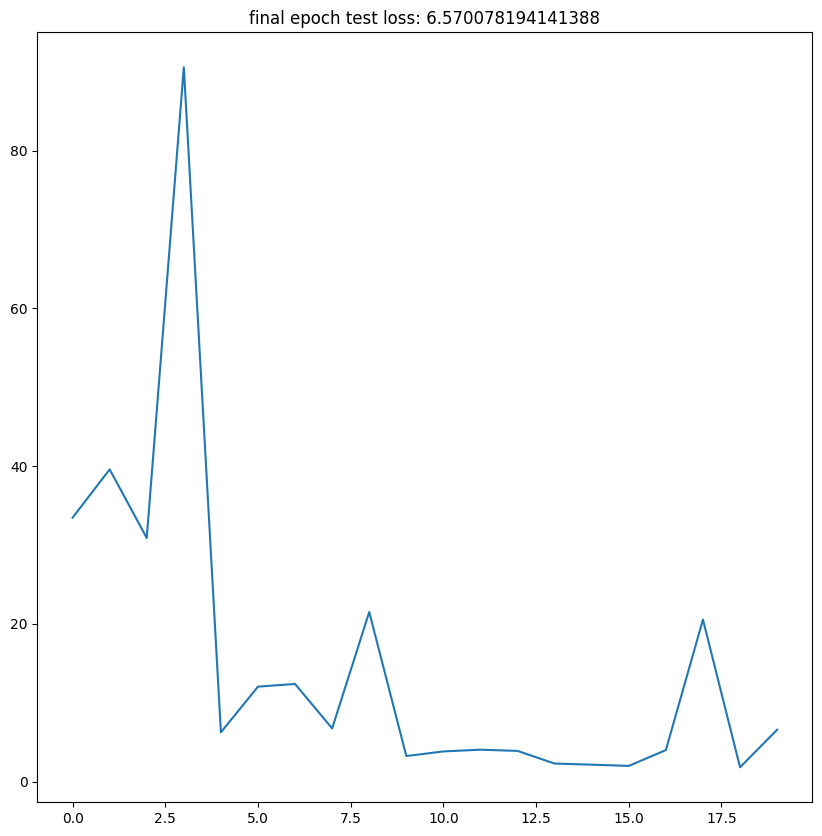

In [ ]:
plt.figure()
plt.title(f"final epoch test loss: {test_loss[-1]}")
plt.plot(np.arange(len(test_loss)),test_loss)

<Figure size 800x800 with 0 Axes>

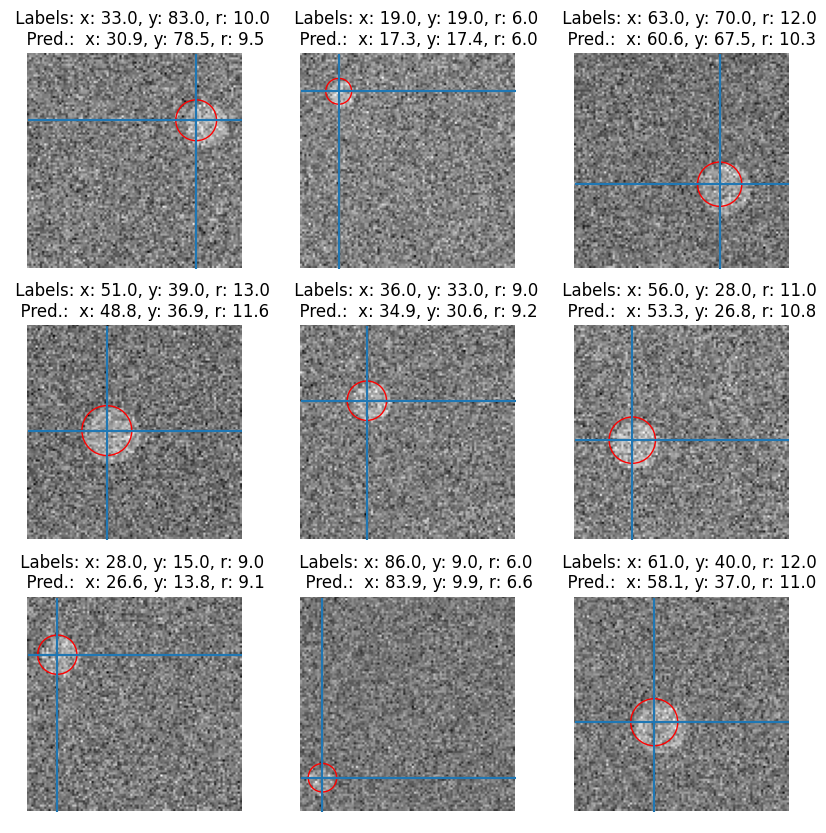

In [ ]:
# visualize the model performance using the images

# set up a canvas of 3 x 3 subplots
plt.rcParams['figure.figsize'] = [10, 10]
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
fig, axes = plt.subplots( rows, cols )

# plot image and prediction
for i in range(rows):
   for j in range(cols):
      # get random index of test sample
      sample_idx = torch.randint(len(testData), size=(1,)).item()
      # get random test sample
      img, label = testData[sample_idx]
      # whats happening here???
      img.unsqueeze_(1)
      # set image to device
      img = img.to(device)
      # get prediction vector (x,y,r) from model
      pred = model(img).squeeze()
      # what does .item() do ???
      x_pred, y_pred, r_pred = pred[0].item(), pred[1].item(), pred[2].item()

      img = img.to('cpu')
      # figure.add_subplot(rows, cols, i)
      axes[i,j].set_title(f" Labels: x: {label[0]}, y: {label[1]}, r: {label[2]}\n  Pred.:  x: {x_pred:.1f}, y: {y_pred:.1f}, r: {r_pred:.1f}")
      axes[i,j].axis("off")
      axes[i,j].imshow(img.squeeze(), cmap="gray") #what does this do???
      axes[i,j].hlines([x_pred,x_pred],0,100)
      axes[i,j].vlines([y_pred,y_pred],0,100)
      circ = Circle((y_pred,x_pred),r_pred,fill = False, edgecolor = "r")
      axes[i,j].add_patch(circ)

# Export the model

In [ ]:
# create a training history data frame
loss_df = pd.DataFrame({f'Loss':test_loss})
loss_df.to_csv(f'{model.__class__.__name__} (N: {noise_lvl}).csv')

In [ ]:
with open(f'{model.__class__.__name__}_state_noise_lvl_{noise_lvl}.pt', 'wb') as f:
    save(model.state_dict(), f)
    print('model has been saved')

model has been saved
